# Projet de BIG DATA  - fiche de route

### *Prédiction de consommation électrique*

##### Objectif : 
- *Déterminer les paramètres responsables de la consommation d'énergie d'un bâtiment*
- *Utiliser ces paramètres pour prédire la consommation future du bâtiment*

##### Présentation des données : 

Nous disposons d'un fichier excel comprennant 10 ans de relevés de la Puissance Active d'un petit bureau à intervalle de 30 minutes.

- Superficie : 
- Année de construction : 
- ...
- Ville : 

Nous disposons également du relevé de température de la ville provennant de la station météorologique.

##### Analyse des données :

Afin d'analyser nos données, nous effectuerons une aggregation sur nos données pour ressortir des indices


### REQUIREMENTS (if not donwload yet)

In [1]:
!pip install azure-cosmos
!pip install pandas
!pip install matplotlib

#### ------------------------------------------------------------------------------------------------------------------------------------------------
### ETAPE 1 : Création du dataset et upload sur CosmosDb

### Dataset Creation

##### Initialisation

In [2]:
import pandas as pd
from matplotlib import pyplot as plt

FILE_PATH_ENERGY = './active_power.xlsx'      # path to the energy consumption data file
FILE_PATH_WEATHER = './seattle_weather.xlsx'  # path to the weather data file
DATE_COLNAME = 'DateTime'                     # name of the Date column

##### FUNCTIONS

In [3]:
def drop_unnamed(df: pd.DataFrame) -> None:
    """ CLEAN FUNCTION : Remove unnamed columns from dataframe"""
    filter_col = [col for col in df if col.startswith('Unnamed')]
    df.drop(columns=filter_col, inplace=True)

##### Load Excels (energy consumption and weather) 

In [4]:
df = pd.read_excel(FILE_PATH_ENERGY, index_col=DATE_COLNAME, parse_dates=True)
df_weather = pd.read_excel(FILE_PATH_WEATHER, index_col=DATE_COLNAME, parse_dates=True)

##### Clean data frames

In [5]:
drop_unnamed(df)
drop_unnamed(df_weather)

##### Present data

In [6]:
df       

,Value
DateTime,
1998-01-01 00:00:00,2.114009
1998-01-01 00:30:01,2.114009
1998-01-01 01:00:02,2.114009
1998-01-01 01:30:03,2.114009
1998-01-01 02:00:04,2.114009
...,...
2014-12-31 08:13:55,2.114009
2014-12-31 08:43:56,2.114009
2014-12-31 09:13:57,2.114009


In [7]:
df_weather

,Temperature,HDD,CDD
DateTime,,,
1998-01-01 00:00:00,7.220000,-8.835,14.945
1998-01-01 01:00:00,7.593333,-8.835,14.945
1998-01-01 02:00:00,7.780000,-8.835,14.945
1998-01-01 03:00:00,7.780000,-8.835,14.945
1998-01-01 04:00:00,8.330000,-8.835,14.945
...,...,...,...
2015-01-01 19:00:00,1.670000,-13.000,20.220
2015-01-01 20:00:00,0.560000,-13.000,20.220
2015-01-01 21:00:00,0.000000,-13.000,20.220


In [8]:
df.size

297840

In [9]:
df_weather.size

447120

##### resample on the same time interval / frequency

In [10]:
# set active power on a 1 hour interval
df = df.resample('H').mean()           

# find first and last common date between weather data and consumption data
first_date = max(df.index[0], df_weather.index[0])
last_date = min(df.index[-1], df_weather.index[-1])

first_date, last_date

(Timestamp('1998-01-01 00:00:00', freq='H'),
 Timestamp('2014-12-31 10:00:00', freq='H'))

##### set both dfs on the same time index

In [11]:
df = df[first_date:last_date]
df_weather = df_weather[first_date:last_date]

##### concat dataframes

In [12]:
df = pd.concat([df, df_weather], axis=1)

In [13]:
df.head()

,Value,Temperature,HDD,CDD
DateTime,,,,
1998-01-01 00:00:00,2.114009,7.220000,-8.835,14.945
1998-01-01 01:00:00,2.114009,7.593333,-8.835,14.945
1998-01-01 02:00:00,2.114009,7.780000,-8.835,14.945
1998-01-01 03:00:00,2.114009,7.780000,-8.835,14.945
1998-01-01 04:00:00,2.114009,8.330000,-8.835,14.945


##### plot data

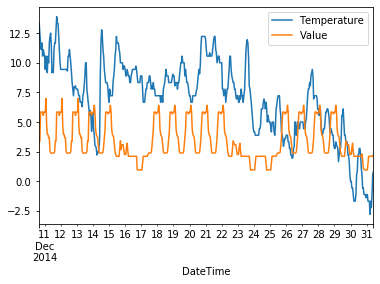

In [14]:
df[['Temperature', 'Value']][-500:].plot()
plt.show()

On voit ici que la température ne semble pas correlée à la consommation d'énergie.
On en déduit que le bâtiment ne dispose pas d'un système de chauffage / refroidissement électrique

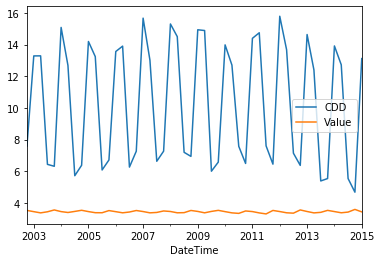

In [15]:
df_3months = df.resample('3M').mean()
df_3months[['CDD', 'Value']][-50:].plot()
plt.show()

### Data ingestion to CosmosDb

In [16]:
import pymongo

##### create the connection

In [17]:
uri = "mongodb://edebaze-bigdata:dYDiQy8VEqwnaGjZVXKtlGkExtSuo1UFOAIKmHA0FqTyFIOAbodJUxjcgVyMQuKTR2ZncpnqQ3YfolZhdU9gBw==@edebaze-bigdata.mongo.cosmos.azure.com:10255/?ssl=true&retrywrites=false&replicaSet=globaldb&maxIdleTimeMS=120000&appName=@edebaze-bigdata@"
client = pymongo.MongoClient(uri)

##### connect to the collections of the EnergyForecasting database

In [18]:
db = client.EnergyForecasting
energy_consumption_collection = db.energy_consumption
weather_collection = db.weather

##### update data to the collections

In [20]:
for index, row in df.iterrows() :
    # ENERGY CONSUMPTION DATA
    # -- create energy data
    ec_data = {
        DATE_COLNAME: index,
        "consumption": row.Value
    }
    # -- push data to collection
    energy_consumption_collection.insert_one(ec_data)

    # WEATHER DATA
    # -- create weather data
    weather_data = {
        DATE_COLNAME: index,
        "temperature": row.Temperature,
        "hdd": row.HDD,
        "cdd": row.CDD,
    }
    # -- push data to collection
    weather_collection.insert_one(weather_data)

The data is uploaded to CosmosDb, now we can do SQL requests ton interact with it

#### ------------------------------------------------------------------------------------------------------------------------------------------------
### ETAPE 2 : SQL REQUESTS

In [21]:
for data in energy_consumption_collection.find():
    print(data)
    break;

{'_id': ObjectId('606dd3eebdabd03f267c0b96'), 'DateTime': datetime.datetime(1998, 1, 1, 0, 0), 'consumption': 2.1140093842}


In [ ]:
energy_consumption_collection